In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from sklearn import metrics
from tqdm import tqdm

df_training = pd.read_json("/export/gaon1/data/jteneggi/data/malaria/training.json")
df_test = pd.read_json("/export/gaon1/data/jteneggi/data/malaria/test_cropped.json")
frames = [df_training, df_test]
df_merged = pd.concat(frames, ignore_index=True)
image_names = []
for i, row in df_merged.iterrows():
    image_names.append(os.path.basename(row["image"]["pathname"]))
df_merged["image_name"] = image_names

exp_mapper = ["hexp/relative_70", "partexp", "gradexp", "deepexp", "lime"]

true_positives_dict = np.load("true_positives.npy", allow_pickle=True).item()
true_positives = []
for c in true_positives_dict:
    for image_path in true_positives_dict[c]:
        true_positives.append(image_path)

exp_df_clips = []
for exp_name in tqdm(exp_mapper):
    exp_df_path = os.path.join("true_positive_explanations", exp_name, f"f1_scores.csv")
        
    if os.path.exists(exp_df_path):
        exp_df = pd.read_csv(exp_df_path)
    else:
        exp_df = pd.DataFrame(columns=["exp_name", "f1", "comp_time"])
            
        exp_comp_times_path = os.path.join("true_positive_explanations", exp_name, f"comp_times.npy")
        exp_comp_times = np.load(exp_comp_times_path)
        
        explanation_dir = os.path.join("true_positive_explanations", exp_name)
        scores = []
        for i, image_path in enumerate(true_positives):
            image = Image.open(image_path)
            image_name = os.path.basename(image_path)
            
            ground_truth = np.zeros((1200, 1600))
            explanation = np.load(os.path.join(explanation_dir, f"{image_name}.npy"))
            query = df_merged.loc[df_merged["image_name"] == image_name]
            # print(image_name)
            for j, row in query.iterrows():
                # print(exp_name, image_name)
                cells = row["objects"]
                for cell in cells:
                    cell_class = cell["category"]
                    if cell_class == "trophozoite":
                        bbox = cell["bounding_box"]
                        upper_left_r = bbox["minimum"]["r"]
                        upper_left_c = bbox["minimum"]["c"]
                        lower_right_r = bbox["maximum"]["r"]
                        lower_right_c = bbox["maximum"]["c"]
                        ground_truth[upper_left_r:lower_right_r+1, upper_left_c:lower_right_c+1] = 1

            explanation_dir = os.path.join("true_positive_explanations", exp_name)
            score = metrics.f1_score(ground_truth.flatten(), explanation.flatten() > 0)

            if exp_comp_times[i] > 0 and score > 0:
                    exp_df = exp_df.append({"exp_name": exp_name, "f1": score, "comp_time": exp_comp_times[i]}, ignore_index=True)
        exp_df.to_csv(exp_df_path)
    exp_df_clips.append(exp_df)
df = pd.concat(exp_df_clips, axis=0)

100%|██████████| 5/5 [00:00<00:00, 74.26it/s]


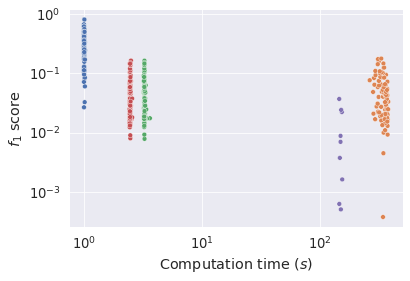

In [2]:
sns.set_theme()
sns.set_context("paper", font_scale=1.5)

g = sns.scatterplot(data=df, x="comp_time", y="f1", hue="exp_name", legend=False)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Computation time ($s$)")
plt.ylabel(r"$f_1$ score")
plt.savefig("f1_time_seaborn.eps")
plt.savefig("f1_time_seaborn.jpg")
plt.savefig("f1_time_seaborn.pdf")